# FGSM Step-by-Step Attack on a Simple Neural Network

This notebook explains the Fast Gradient Sign Method (FGSM) using a minimal example: a single neuron with two inputs.

## Fast Gradient Sign Method — Overview

FGSM is an adversarial attack technique introduced by Goodfellow et al. in 2015 ([Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572)). It perturbs the input by a small amount in the direction of the gradient of the loss with respect to the input, causing the model to make an incorrect prediction.

$$
x_{adv} = x + \epsilon \cdot \text{sign}\left(\nabla_x J(\theta, x, y)\right)
$$

Where:
- $x$: original input
- $\epsilon$: small scalar (perturbation size)
- $J(\theta, x, y)$: loss function
- $\nabla_x$: gradient of the loss w.r.t input
- $x_{adv}$: adversarial example

## Simple Neural Network

We use a single neuron with sigmoid activation:

$$
z = w_1 x_1 + w_2 x_2 + b
$$
$$
\hat{y} = \sigma(z) = \frac{1}{1 + e^{-z}}
$$

Where:
- $x = [x_1, x_2]$ is the input (e.g., two pixels)
- $w = [w_1, w_2]$ are the weights
- $b$ is the bias
- $\sigma(z)$ is the sigmoid function
- $\hat{y}$ is the predicted output


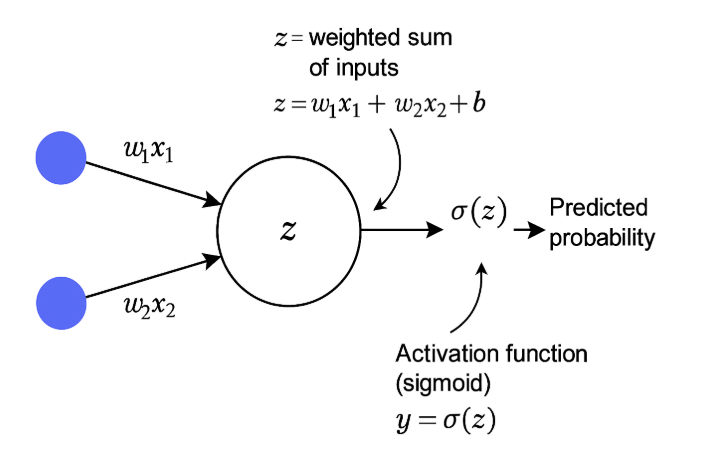

In [1]:
import numpy as np

# Input
x = np.array([[1.08], [1.0]])  # 2-pixel input
y_true = 1                     # Ground truth label

# Weights and bias
w = np.array([[0.5], [-0.5]])
b = 0.0

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Cross-entropy loss
def cross_entropy(y_hat, y):
    return - (y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

### What is Cross-Entropy Loss?

Binary cross-entropy is a commonly used loss function in classification tasks. It measures the distance between the predicted probability and the true class label.

$$
J(\theta, x, y) = -\left[y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y})\right]
$$

Where:
- $y$: true label (0 or 1)
- $\hat{y}$: model's predicted probability

When prediction is accurate, the loss is close to zero. As prediction deviates from the true label, the loss increases.

## Step 1: Forward Pass

We compute the output of the neuron based on the current parameters — weights, bias, and activation function — and the input vector:

$$
z = w^T x + b
$$
$$
\hat{y} = \sigma(z)
$$

In [2]:
z = np.dot(w.T, x) + b
z

array([[0.04]])

In [3]:
y_pred = sigmoid(z)[0][0]
y_pred

np.float64(0.5099986668799655)

## Step 2: Compute Loss

Using binary cross-entropy:

$$
J(\theta, x, y) = -\log(\hat{y})
$$

It is assumed that the true label $y = 1$. That is, when the class is positive, the second term $(1 - y) \log(1 - \hat{y})$ becomes zero.

In [4]:
loss = cross_entropy(y_pred, y_true)
loss

np.float64(0.6733471672280339)

## Step 3: Compute Gradient via Chain Rule

We want to find the derivative of the loss function $J$ with respect to the input $x$, i.e., $\frac{dJ}{dx}$. Since $J$ depends on $x$ through several intermediate variables ($\hat{y}$ and $z$), we apply the **chain rule**.

### Why use the chain rule?

The loss function $J$ depends on the prediction $\hat{y}$, which depends on the linear input $z$, and $z$ in turn depends on the input $x$:

$$
J \to \hat{y} \to z \to x
$$

To find $\frac{dJ}{dx}$, we multiply the derivatives along this chain:

$$
\frac{dJ}{dx} = \frac{dJ}{d\hat{y}} \cdot \frac{d\hat{y}}{dz} \cdot \frac{dz}{dx}
$$

### Breakdown of each term

1. $\frac{dJ}{d\hat{y}} = - \frac{y}{\hat{y}} + \frac{1 - y}{1 - \hat{y}}$

   - The loss function is binary cross-entropy: $-\left[y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y})\right]$
   - The derivative with respect to $\hat{y}$ is: $\frac{dJ}{d\hat{y}} = - \frac{y}{\hat{y}} + \frac{1 - y}{1 - \hat{y}}$
   - This term shows how changes in the predicted probability affect the loss.

2. $\frac{d\hat{y}}{dz} = \hat{y}(1 - \hat{y})$

   - $\hat{y} = \sigma(z)$, where $\sigma$ is the sigmoid activation function.
   - The derivative of the sigmoid is: $\frac{d\sigma}{dz} = \sigma(z)(1 - \sigma(z)) = \hat{y}(1 - \hat{y})$
   - This term shows how changes in the linear input $z$ affect the neuron's output $\hat{y}$.

3. $\frac{dz}{dx} = w$

   - $z = w^T x + b$ is a linear combination of inputs.
   - The derivative with respect to $x$ is simply the weights $w$, since $b$ is constant.
   - This shows how changes in the input $x$ affect the linear input $z$.

### Putting it all together

Multiplying the terms, we get the gradient of the loss with respect to the input:

$$
\frac{dJ}{dx} = \left(-\frac{y}{\hat{y}} + \frac{1 - y}{1 - \hat{y}}\right) \cdot \hat{y}(1 - \hat{y}) \cdot w = (\hat{y} - y) \cdot w
$$

This gradient is used to update model parameters or analyze sensitivity.


In [5]:
grad_x = (y_pred - y_true) * w
grad_x

array([[-0.24500067],
       [ 0.24500067]])

This gradient vector indicates how the loss function changes with respect to each input feature. The negative value for the first feature suggests that increasing this feature will decrease the loss, while the positive value for the second feature means increasing it will increase the loss. This information is crucial for understanding which input features most influence the model's prediction and how adversarial perturbations can be crafted to manipulate the output.

## Step 4: Apply FGSM Attack

FGSM formula:

$$
x_{adv} = x + \epsilon \cdot \text{sign}(\nabla_x J(\theta, x, y))
$$

The gradient $\nabla_x J(\theta, x, y)$ shows how the loss changes when each input feature is slightly modified.

Taking the **sign** of this gradient gives the direction to increase the loss most rapidly for each input dimension (either +1 or -1).

Multiplying by a small scalar $\epsilon$ controls the magnitude of the perturbation, keeping it imperceptible but effective.

Adding this perturbation to the original input $x$ creates the adversarial example $x_{adv}$ that is designed to fool the model into making incorrect predictions.

This approach leverages the model’s sensitivity to input changes to craft minimal but impactful perturbations.

Let $\epsilon = 0.1$

In [6]:
x

array([[1.08],
       [1.  ]])

In [7]:
epsilon = 0.1
sign_grad = np.sign(grad_x)
x_adv = x + epsilon * sign_grad
x_adv

array([[0.98],
       [1.1 ]])

## Step 5: Prediction After Attack

Let's see how the prediction changes after the adversarial perturbation.

In [8]:
z_adv = np.dot(w.T, x_adv) + b
y_pred_adv = sigmoid(z_adv)[0][0]
y_pred_adv

np.float64(0.4850044983805899)

In [9]:
print(f"Original prediction = {y_pred:.4f}")
print(f"Prediction after attack = {y_pred_adv:.4f}")
print(f"Confidence drop: {y_pred - y_pred_adv:.4f}")

Original prediction = 0.5100
Prediction after attack = 0.4850
Confidence drop: 0.0250


The model started making a mistake because the adversarial attack slightly perturbed the input, causing the predicted probability to drop below the classification threshold of 0.5.

## Conclusion

- We constructed a simple neural network with two inputs and a sigmoid activation.
- Performed a forward pass and calculated the loss using binary cross-entropy.
- Computed gradients manually using the chain rule.
- Generated an adversarial input using the FGSM method.

**Key Insight:** Even a small perturbation can significantly affect the model's output, highlighting the vulnerability of neural networks to adversarial attacks.